In [1]:
import pandas as pd
import matplotlib.pyplot as plt

csvFileName = "fitbitHRdf.csv"
fitbitHRdf = pd.read_parquet('fitbitHRdf.parquet.gzip') 
#fitbitHRdf = pd.read_csv(csvFileName, 
#                         index_col="sampleDT", 
#                         parse_dates=["sampleDT"])

In [2]:
fitbitHRdf

,confidence,value
sampleDT,,
2021-11-22 17:01:48-07:00,0,70
2021-11-22 17:02:03-07:00,0,76
2021-11-22 17:02:08-07:00,1,79
2021-11-22 17:02:13-07:00,2,67
2021-11-22 17:02:28-07:00,2,66
...,...,...
2022-03-14 06:59:39-07:00,2,88
2022-03-14 06:59:44-07:00,2,89
2022-03-14 06:59:49-07:00,3,89


Text(0.5, 0, 'BPM')

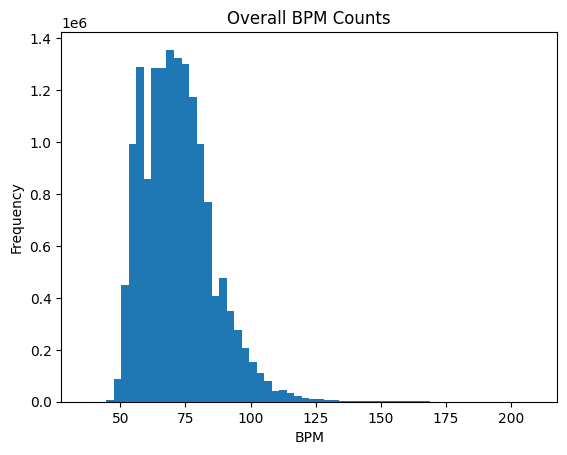

In [3]:
ax = fitbitHRdf.value.plot.hist(bins=60, title="Overall BPM Counts")
ax.set_xlabel("BPM")

In [7]:
fitbitHRdf = fitbitHRdf.sort_index()
timesSeries = pd.Series(fitbitHRdf.index)
betweenMesures = ((timesSeries.shift(-1) - timesSeries)).astype('timedelta64[s]')
betweenMesures

0           15.0
1           10.0
2            5.0
3            5.0
4            5.0
            ... 
15457552    10.0
15457553     5.0
15457554    15.0
15457555    15.0
15457556     NaN
Name: sampleDT, Length: 15457557, dtype: float64

In [8]:
fitbitHRdf["timeToNextReading"] = pd.Series(index=fitbitHRdf.index, data=betweenMesures.values)
betweenMesures = betweenMesures.dropna()
fitbitHRdf = fitbitHRdf.dropna()
fitbitHRdf

,confidence,value,timeToNextReading
sampleDT,,,
2020-05-13 17:02:19-07:00,0,70,15.0
2020-05-13 17:02:34-07:00,1,70,10.0
2020-05-13 17:02:44-07:00,1,79,5.0
2020-05-13 17:02:49-07:00,2,80,5.0
2020-05-13 17:02:54-07:00,2,79,5.0
...,...,...,...
2024-07-17 22:20:10-07:00,3,62,5.0
2024-07-17 22:20:15-07:00,2,62,10.0
2024-07-17 22:20:25-07:00,3,63,5.0


In [19]:
fitbitHRdf["timeToNextReading"].describe()

count    1.545756e+07
mean     8.530813e+00
std      6.558580e+02
min      1.000000e+00
25%      5.000000e+00
50%      5.000000e+00
75%      1.000000e+01
max      2.060050e+06
Name: timeToNextReading, dtype: float64

Text(0.5, 0, 'Interval (sec)')

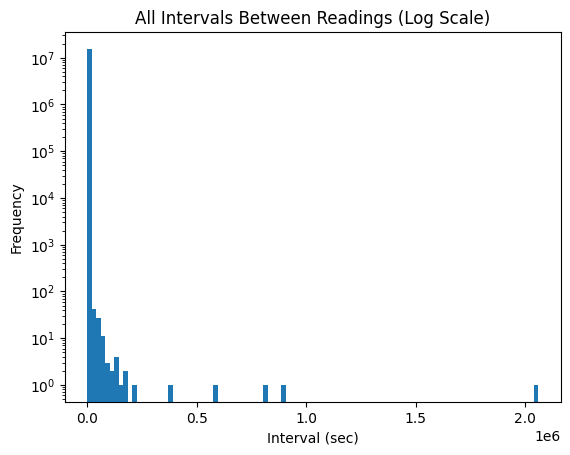

In [12]:
ax = betweenMesures.plot.hist(bins=100, log=True, title="All Intervals Between Readings (Log Scale)")
ax.set_xlabel("Interval (sec)")

Text(0.5, 0, 'Interval (sec)')

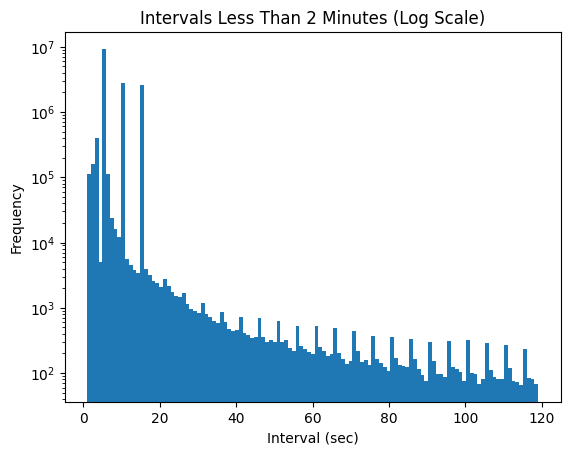

In [22]:
ax = betweenMesures.loc[betweenMesures<120].plot.hist(bins=119, log=True, title="Intervals Less Than 2 Minutes (Log Scale)")
ax.set_xlabel("Interval (sec)")


Text(0.5, 0, 'Interval (sec)')

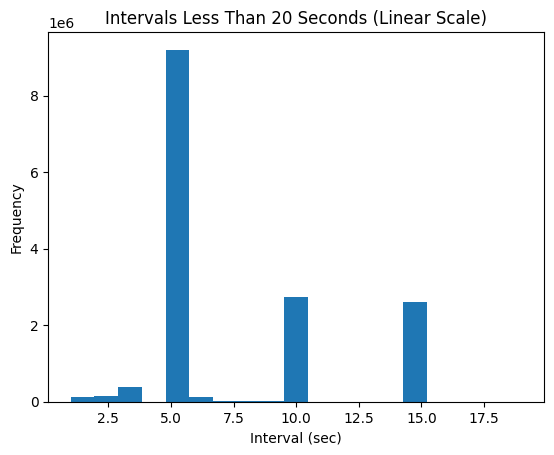

In [20]:
ax = betweenMesures.loc[betweenMesures<20].plot.hist(bins=19, title="Intervals Less Than 20 Seconds (Linear Scale)")
ax.set_xlabel("Interval (sec)")
